<img src = "../../Data/bgsedsc_0.jpg">

# Project: Ensembles

In [57]:
## Set up ----
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import random
import time
import scipy
import datetime
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import time

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder,  scale
import category_encoders as ce
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# kernel approximators
from sklearn.kernel_approximation import Nystroem, RBFSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import gc
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Random state
rand_state = 1111
np.random.seed(rand_state) # impose random seed for reproducibility

# Some base models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble, TemporalEnsemble

# Training dataset
data=pd.read_csv('../Data/mimic_train.csv')
data_test=pd.read_csv('../Data/mimic_test_los.csv')

## Pre-processing

I have moved the preprocessing to a separate file as it's quite extensive and this way it's more easily shared across prediction problems. It saves data which I read below in order to not have to run pre-processing each time. If need be, pre-processing can be run by uncommenting the code in the cell below.

In [58]:
#%run ./preproc.ipynb

In [59]:
# Read pre-processed data:
y = data.loc[:,'LOS']
X = pd.read_csv("../Data/los/X_preproc.csv")
X_test = pd.read_csv("../Data/los/X_test_preproc.csv")
data = pd.concat([y,X], axis=1)

In [60]:
# Check:
print(X.shape)
print(X_test.shape)
print(y.shape)

(20885, 43)
(5221, 43)
(20885,)


In [61]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(
    np.array(X),
    y, 
    test_size=0.7, random_state=rand_state
)

target_name = 'LOS'
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Prediction

In [62]:
def get_models():
    #Generate a library of simple learners
    svr = SVR(C=100)
    knn = KNeighborsRegressor(n_neighbors=3)
    rf = RandomForestRegressor(n_estimators=10, max_features=3, random_state=rand_state)
    xgb = XGBRegressor(
        learning_rate=0.01, 
        objective='reg:squarederror', 
        n_estimators=100, 
        subsample=0.5, 
        max_depth=6
    )
    models = {
        'svm': svr,
        'knn': knn,
        'random forest': rf,
        'xgb': xgb      
    }
    return models

def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    #Fit models in list on training set and return preds
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = np.sqrt(mean_squared_error(y, P.loc[:, m]))
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

svm... done
knn... done
random forest... done
xgb... done
Done.

Scoring models.
svm                       : 4.858
knn                       : 5.287
random forest             : 5.074
xgb                       : 4.929


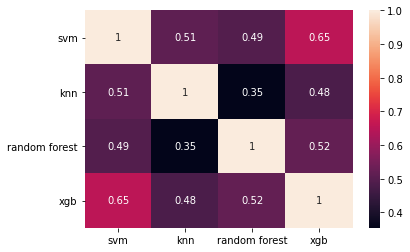

In [63]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,my_scores= score_models(P, y_test)
#Plot correlations
sns.heatmap(P.corr(), annot=True)
plt.show()

Initialize a `results` list to store the accuracy scores:

In [64]:
# Save results
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('svm', 4.858106141496884),
 ('knn', 5.287064138896556),
 ('random forest', 5.074253535622031),
 ('xgb', 4.929350143535956)]

### Averaging

We will begin by simply averaging the predictions and add the resulting score to the results. We actually get quite a bit of improvement here, likely due to the fact that KNN predictions are so different from the others.

In [65]:
# Simple average
AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg'])
my_model_avg,my_scores_avg= score_models(AvgPred, y_test)

Scoring models.
Avg                       : 4.763


In [66]:
# Save results
results=results+[(model,score) for model,score in zip(my_model_avg,my_scores_avg)]

### Stacking

Stacking does not lead to much improvement:

In [ ]:
meta_learner = ExtraTreesRegressor(
    n_estimators=20,
    bootstrap=True,
    max_features=0.7
)

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=2,
    backend="multiprocessing",
    n_jobs=3
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict(X_test)
scoreStackXtres=mean_squared_error(y_test, p_sl[:, 1])
print("\nSuper Learner ROC-AUC score: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             

In [ ]:
# Save results
results=results+[('StackingExtraTrees',scoreStackXtres)]
results

### Feature propagation

Let's try to propagate the most important features (as per the random forest model):

In [44]:
n_features = 5
rf_features = models['rf'].feature_importances_
rf_features_ordered = pd.Series(data=rf_features, index=range(len(rf_features))).sort_values(ascending=False)
to_propagate = list(rf_features_ordered[:n_features].index)
pointer = to_propagate

Evidently this leads to improvement with stacking:

In [45]:
sl2 = SuperLearner(
    folds=5,
    random_state=rand_state,
    verbose=2,
    backend="multiprocessing",
    n_jobs=3
)

# Add the base learners and the meta learner
sl2.add(list(models.values()), proba=True, propagate_features=pointer)
sl2.add_meta(meta_learner, proba=True)

# Train the ensemble
sl2.fit(X_train, y_train)

# Predict the test set
p_sl2 = sl2.predict_proba(X_test)
scoreStackXtres2=mean_squared_error(y_test, p_sl2[:, 1])
print("\nSuper Learner 2 ROC-AUC score: %.3f" % scoreStackXtres2)


Fitting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:03

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:02

Super Learner 2 ROC-AUC score: 0.705


In [46]:
# Save results
results=results+[('StackingExtraTrees2',scoreStackXtres2)]
results

[('knn', 0.6815822366805124),
 ('logistic', 0.6968223449721356),
 ('rf', 0.6960534144064976),
 ('Avg', 0.7172982768313784),
 ('StackingExtraTrees', 0.679624772800463),
 ('StackingExtraTrees2', 0.7051598174762158)]

### Blending

In [47]:
bl =  BlendEnsemble(test_size=0.2, random_state=rand_state,n_jobs=3)

# Add the base learners and the meta learner
bl.add(list(models.values()), proba=True, propagate_features=pointer)
bl.add_meta(meta_learner, proba=True)

# Train the ensemble
bl.fit(X_train, y_train)

# Predict the test set
p_bl = bl.predict_proba(X_test)
scoreBlendXtrees=mean_squared_error(y_test, p_bl[:, 1])
print("\nBlend ROC-AUC score: %.3f" % scoreBlendXtrees)


Blend ROC-AUC score: 0.679


In [48]:
# Save results
results=results+[('BlendXtrees',scoreBlendXtrees)]
results

[('knn', 0.6815822366805124),
 ('logistic', 0.6968223449721356),
 ('rf', 0.6960534144064976),
 ('Avg', 0.7172982768313784),
 ('StackingExtraTrees', 0.679624772800463),
 ('StackingExtraTrees2', 0.7051598174762158),
 ('BlendXtrees', 0.6790311884241496)]

### Subsemple

In [49]:
from sklearn.cluster import KMeans
sub = Subsemble(partitions=3, folds=4,partition_estimator=KMeans(3, random_state=rand_state),
               random_state=rand_state)

sub.add(list(models.values()), proba=True, propagate_features=pointer)
sub.add_meta(meta_learner, proba=True)

# Train the ensemble
sub.fit(X_train, y_train)

# Predict the test set
p_sub = sub.predict_proba(X_test)
scoreSubS=mean_squared_error(y_test, p_sub[:, 1])
print("\nSubSamble ROC-AUC score: %.3f" % scoreSubS)


SubSamble ROC-AUC score: 0.721


In [50]:
# Save results
results=results+[('SubSambleXtrees',scoreSubS)]
results

[('knn', 0.6815822366805124),
 ('logistic', 0.6968223449721356),
 ('rf', 0.6960534144064976),
 ('Avg', 0.7172982768313784),
 ('StackingExtraTrees', 0.679624772800463),
 ('StackingExtraTrees2', 0.7051598174762158),
 ('BlendXtrees', 0.6790311884241496),
 ('SubSambleXtrees', 0.7207758625395041)]

### Multi-layer

Let's define a second meta learner and run a multi-layer ensemble:

In [51]:
meta_learner_2 = RandomForestClassifier(n_estimators=10, max_features=3, random_state=rand_state)

In [52]:
ensemble = SequentialEnsemble(random_state=rand_state)

# The initial layer is a blended layer, same as a layer in the BlendEnsemble
ensemble.add('blend',
             list(models.values()), proba=True, propagate_features=pointer,random_state=rand_state)

# The second layer is a stacked layer, same as a layer of the SuperLearner
ensemble.add('stack', [meta_learner, meta_learner_2], proba=True,random_state=rand_state)

# The third layer is a subsembled layer, same as a layer of the Subsemble
ensemble.add('subsemble', [meta_learner, meta_learner_2], proba=True,random_state=rand_state)

# The meta estimator is added as in any other ensemble
ensemble.add_meta(LogisticRegression(), proba=True)
# Train the ensemble
ensemble.fit(X_train, y_train)

# Predict the test set
p_multi = ensemble.predict_proba(X_test)
scoreMultiE=mean_squared_error(y_test, p_multi[:, 1])
print("\nMulti-Ensemble ROC-AUC score: %.3f" % scoreMultiE)


Multi-Ensemble ROC-AUC score: 0.648


In [53]:
# Save results
results=results+[('Multi-Layer',scoreMultiE)]
results

[('knn', 0.6815822366805124),
 ('logistic', 0.6968223449721356),
 ('rf', 0.6960534144064976),
 ('Avg', 0.7172982768313784),
 ('StackingExtraTrees', 0.679624772800463),
 ('StackingExtraTrees2', 0.7051598174762158),
 ('BlendXtrees', 0.6790311884241496),
 ('SubSambleXtrees', 0.7207758625395041),
 ('Multi-Layer', 0.647537102434924)]

# Model evaluation with test set



In [54]:
results_df=pd.DataFrame(results)
results_df.columns=['Method','AUC_score']
results_df= results_df.sort_values(by='AUC_score', ascending=False)
results_df.head()

,Method,AUC_score
7,SubSambleXtrees,0.720776
3,Avg,0.717298
5,StackingExtraTrees2,0.705160
1,logistic,0.696822
2,rf,0.696053


(0.65, 0.75)

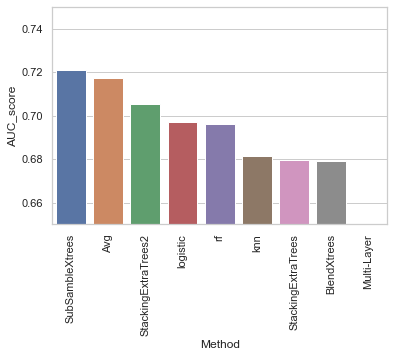

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = sns.barplot(x="Method", y="AUC_score", data=results_df)
ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.ylim(0.65,0.75)